# Lab

### Configuration

In [1]:
import os.path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
from matplotlib.widgets import Button
import json as js
import time
import csv

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15


def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax

    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))

    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()

    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []

    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)

    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points = None, lines = None):
        self.points = points or []
        self.lines = lines or []

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs

    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs

    def add(self, line):
        self.lines.append(line)

    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = None, points = None, lines = None, json = None):
        points = points or []
        lines = lines or []
        if json is None:
            self.scenes = scenes or [Scene()]
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]],
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]])
                           for scene in js.loads(json)]

    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]

    def add_scene(self, scene):
        self.scenes.append(scene)

    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def to_json(self) -> str:
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points],
                          "lines":[linesCol.lines for linesCol in scene.lines]}
                         for scene in self.scenes])

    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None

    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None

    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None

    def draw(self, buttons = False, autoscaling = True):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        if buttons:
            self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw(autoscaling)

    @staticmethod
    def save_to_file(file_name: str):
        plt.savefig(file_name + '.png' if file_name.find('.') == -1 else file_name)


### Rozwiązanie

In [3]:
from typing import Callable
from enum import Enum

#config
epsilon = np.float64(1e-8)

point_type = tuple[np.float64, np.float64]
rectangle_type = tuple[point_type, point_type]
vector_type = tuple[point_type, point_type]
matrix_type = list[list[np.float64]]

class PointRelativePosition(Enum):
    LEFT = 1
    COLLINEAR = 2
    RIGHT = 3


class DeterminantCalculation:
    def __init__(self, matrix_creation: Callable[[point_type, vector_type], matrix_type], det_calc: Callable[[matrix_type], np.float64]):
        self.create_matrix = matrix_creation
        self.calc_det = det_calc

    def calc(self, a, b, c):
        matrix = self.create_matrix(c, (a, b))
        det = self.calc_det(matrix)

        return det


class PointsOrderType(Enum):
    ANGLE = 1


class Vector2d:
    def __init__(self, x: np.float64, y: np.float64):
        self.x = x
        self.y = y

        self._cmp_function = lambda p1, p2: p1.x == p2.x and p1.y == p2.y

    @staticmethod
    def from_tuple(tuple_point: point_type):
        return Vector2d(*tuple_point)

    def set_cmp_function(self, cmp_function: Callable):
        self._cmp_function = cmp_function

    def to_tuple(self) -> point_type:
        return self.x, self.y


    def __lt__(self, other):
        return self._cmp_function(self, other) < 0

    def __eq__(self, other):
        return self._cmp_function(self, other) == 0

    def __gt__(self, other):
        return self._cmp_function(self, other) > 0

    def __add__(self, other):
        return Vector2d(self.x + other.x, self.y + other.y)

    def __str__(self):
        return f'Vector(x={self.x}, y={self.y})'

    def __repr__(self):
        return str(self)


class BoundVector:
    def __init__(self, a: Vector2d, b: Vector2d):
        self.a = a
        self.b = b

In [4]:
# data generation functions


def generate_random_points(no_of_points: int, mini_x = -1000.0, maxi_x = 1000.0, mini_y = -1000.0, maxi_y = 1000.0) -> list:
    xs = np.random.uniform(mini_x, maxi_x, no_of_points)
    ys = np.random.uniform(mini_y, maxi_y, no_of_points)

    return list(zip(xs, ys))

def generate_circle_points(no_of_points = 1000, circle_radius = 100) -> list:
    fis = np.random.uniform(0, 2 * np.pi, no_of_points)
    xs = circle_radius * np.cos(fis)
    ys = circle_radius * np.sin(fis)

    return list(zip(xs, ys))

def generate_rectangle_perimeter_points(no_of_points: int, rectangle: rectangle_type):
    p1, p2 = rectangle
    a = abs(p1[0] - p2[0])
    b = abs(p1[1] - p2[1])
    perimeter = 2 * a + 2 * b

    ts = np.random.uniform(0, perimeter, no_of_points)

    points = []

    for t in ts:
        if t <= a:
            x, y = t, 0
        elif a < t <= a + b:
            x, y = a, t - a
        elif a + b < t <= 2*a + b:
            x, y = t - (a + b), b
        else:
            x, y = 0, t - (2*a + b)

        x += p1[0]
        y += p1[1]

        points.append((x, y))

    return points


def generate_dataset_d(no_of_points_on_edges: int, no_of_points_on_vertices: int, square: rectangle_type):
    p1, p3 = square
    p1, p3 = (min(p1[0], p3[0]), min(p1[1], p3[1])), (max(p1[0], p3[0]), max(p1[1], p3[1]))
    p2 = p1[0], p3[1]
    p4 = p3[0], p1[1]
    points = [p1, p2, p3, p4]

    a = p3[0] - p1[0]

    points += [(p1[0] + t, p1[1] + t) for t in np.random.uniform(0, a, no_of_points_on_vertices)] # vertex1
    points += [(p1[0] + t, p3[1] - t) for t in np.random.uniform(0, a, no_of_points_on_vertices)] # vertex2
    points += [(p1[0], p1[1] + t) for t in np.random.uniform(0, a, no_of_points_on_edges)]
    points += [(p1[0] + t, p1[1]) for t in np.random.uniform(0, a, no_of_points_on_edges)]

    return points


def generate_default_datasets():
    return {
        'A': generate_random_points(100, -100.0, 100.0, -100.0, 100.0),
        'B': generate_circle_points(100, 10),
        'C': generate_rectangle_perimeter_points(100, ((-10.0, -10.0), (10.0, 10.0))),
        'D': generate_dataset_d(20, 25, ((-10, -10), (10, 10))),
    }


In [5]:
# visualization functions

def draw_points(points: list[tuple]):
    points_collection = PointsCollection(points=points)
    plot = Plot(points=[points_collection])
    plot.draw()

    return plot

def draw_and_save(plot: Plot, filename: str, limits = None):
    plot.draw(autoscaling = True if limits is None else False)
    ax = plt.gca()
    x_lim, y_lim = limits
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    file_dir = filename[:filename.rindex('/')]
    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    plt.savefig(filename)




In [6]:
from typing import Callable


def convert_tuple_points_to_points(points: list[point_type]):
    return list(map(Vector2d.from_tuple, points))


def create_2x2_matrix(c: Vector2d, ab_vector: BoundVector):
    xA, yA = ab_vector.a.to_tuple()
    xB, yB = ab_vector.b.to_tuple()

    matrix = [
        [xA - c.x, yA - c.y],
        [xB - c.x, yB - c.y]
    ]

    return matrix


def calc_det(matrix):  # calculation of matrix det written for WDI
    def calc_det_recur(matrix, y, il, poss, perm, inv):
        if y >= len(matrix):
            nonlocal su

            if inv % 2 == 0:
                sign = 1
            else:
                sign = -1

            su += sign * il
            return il

        for curr_i in poss:
            inv_c = inv
            for perm_el in perm:
                if perm_el > curr_i:
                    inv_c += 1

            calc_det_recur(matrix, y + 1, il * matrix[y][curr_i], [i for i in poss if i != curr_i], perm + [curr_i],
                           inv_c)

    su = 0
    poss = [i for i in range(len(matrix))]
    for curr_i in range(len(matrix[0])):
        calc_det_recur(matrix, 1, matrix[0][curr_i], [i for i in poss if i != curr_i], [curr_i], 0)

    return su

class PointClassifier:
    def __init__(self, collinear_tolerance: np.float64, point_det_function: Callable[[Vector2d, BoundVector], np.float64]):
        self.calc_det = point_det_function

        self.collinear_tolerance = collinear_tolerance

    def classify_point(self, point: Vector2d, vector: BoundVector):
        det = self.calc_det(point, vector)

        if abs(det) < self.collinear_tolerance:
            return PointRelativePosition.COLLINEAR
        if det > 0:
            return PointRelativePosition.LEFT
        if det < 0:
            return PointRelativePosition.RIGHT


class PointsComparator:
    def __init__(self, a: Vector2d, point_classifier: PointClassifier):
        self.a = a
        self.point_classifier = point_classifier

    def compare_angles(self, b: Vector2d, c: Vector2d) -> int:
        c_rel_pos = self.point_classifier.classify_point(c, BoundVector(self.a, b))

        if c_rel_pos == PointRelativePosition.LEFT:
            return -1 # c is 'smaller' than b
        if c_rel_pos == PointRelativePosition.COLLINEAR:
            return 0
        if c_rel_pos == PointRelativePosition.RIGHT:
            return 1 # c is 'greater' than b

    def compare_distance(self, b: Vector2d, c: Vector2d):
        db = dist(self.a.to_tuple(), b.to_tuple())
        dc = dist(self.a.to_tuple(), c.to_tuple())

        return np.sign(dc - db)


    def __call__(self, b, c):
        return self.compare_angles(b, c)


In [7]:
class Algorithm:
    def __init__(self, point_classifier: PointClassifier):
        self.point_classifier = point_classifier

        self._algorithm: Callable = lambda x: None

        self.save_visualization = False

        self.start_time = None
        self.end_time = None


    def run(self, points: list[Vector2d], save_vis = False, measure_time = False):
        self.save_visualization = save_vis
        if measure_time:
            self.start_time = time.perf_counter_ns()

        ans =  self._algorithm(points)

        if measure_time:
            self.end_time = time.perf_counter_ns()

        return ans

    def get_measured_time(self):
        return self.end_time - self.start_time

In [8]:
%matplotlib notebook

# Graham algorithm

class GrahamAlgorithm(Algorithm):
    def __init__(self, point_classifier: PointClassifier):
        # self.points_comparator = points_comparator
        super().__init__(point_classifier)
        # self.point_classifier = point_classifier

        self._algorithm = self.graham_algorithm

    def get_only_the_furthest_from_equal_angles(self, points: list[Vector2d], points_comparator: PointsComparator):
        filtered_points = []
        furthest = points[0]
        for i in range(1, len(points)):
            if points_comparator.compare_angles(points[i-1], points[i]) == 0:
                if points_comparator.compare_distance(furthest, points[i]) > 0:
                    furthest = points[i]
            else:
                filtered_points.append(furthest)
                furthest = points[i]

        filtered_points.append(furthest)
        return filtered_points

    def set_points_comparison_to_angle(self, point_a: Vector2d, points: list[Vector2d]):
        points_comparator = PointsComparator(point_a, self.point_classifier)
        for point in points:
            point.set_cmp_function(points_comparator.compare_angles)

        return points_comparator

    def graham_algorithm(self, points: list[Vector2d]) -> list[Vector2d]:
        min_point = min(points, key=lambda p: (p.y, p.x))


        # print(points)

        points = list(filter(lambda p: p.x != min_point.x or p.y != min_point.y, points))

        # print('filtered:', points)

        points_comparator_respect_min_point = self.set_points_comparison_to_angle(min_point, points)

        points.sort(reverse=False)
        # print(points)

        filtered_points = self.get_only_the_furthest_from_equal_angles(points, points_comparator_respect_min_point)
        # print("really_filtered", points)

        stack = [min_point, filtered_points[0]]

        if self.save_visualization:
            max_y = max(points, key=lambda p: p.y).y
            y_lim = [min_point.y - 10, max_y + 10]
            max_x = max(points, key=lambda p: p.x).x
            min_x = min(points, key=lambda p: p.x).x
            x_lim = [min_x - 10, max_x + 10]

            no_of_digits = 4
            current_point = []
            current_point_collection = PointsCollection(points=current_point, color='b')
            convex_hull_tuple_points = [stack[0].to_tuple()]
            convex_hull_collection = PointsCollection(points=convex_hull_tuple_points, color='g')
            min_point_coll = PointsCollection(points=[min_point.to_tuple()], color='r')
            all_points_coll = PointsCollection(points=list(map(lambda x: x.to_tuple(), points)), color='gray')

            convex_hull_lines = []
            convex_hull_lines_coll = LinesCollection(lines=convex_hull_lines, color='g')

            vis_i = 0
            plot = Plot(points=[all_points_coll, convex_hull_collection, min_point_coll, current_point_collection], lines=[convex_hull_lines_coll])

            draw_and_save(plot, f'./graham/{str(vis_i).zfill(no_of_digits)}.png', limits=(x_lim, y_lim))
            vis_i += 1

            convex_hull_tuple_points.append(stack[1].to_tuple())
            convex_hull_lines.append([stack[0].to_tuple(), stack[1].to_tuple()])

            draw_and_save(plot, f'./graham/{str(vis_i).zfill(no_of_digits)}.png', limits=(x_lim, y_lim))
            vis_i += 1

        for point in filtered_points[1:]:
            if self.save_visualization:
                current_point.clear()
                current_point.append(point.to_tuple())

                draw_and_save(plot, f'./graham/{str(vis_i).zfill(no_of_digits)}.png', limits=(x_lim, y_lim))
                vis_i += 1

            while self.point_classifier.classify_point(point, BoundVector(stack[-2], stack[-1])) in [PointRelativePosition.RIGHT, PointRelativePosition.COLLINEAR]:
                stack.pop()
                if self.save_visualization:
                    convex_hull_tuple_points.pop()
                    if len(convex_hull_lines) > 0:
                        convex_hull_lines.pop()

                    draw_and_save(plot, f'./graham/{str(vis_i).zfill(no_of_digits)}.png', limits=(x_lim, y_lim))
                    vis_i += 1

            stack.append(point)
            if self.save_visualization:
                convex_hull_tuple_points.append(point.to_tuple())

                if len(convex_hull_tuple_points) >= 2:
                    convex_hull_lines.append([convex_hull_tuple_points[-2], convex_hull_tuple_points[-1]])

                draw_and_save(plot, f'./graham/{str(vis_i).zfill(no_of_digits)}.png', limits=(x_lim, y_lim))
                vis_i += 1

        if self.save_visualization:
            if len(convex_hull_tuple_points) >= 2:
                convex_hull_lines.append([convex_hull_tuple_points[-1], convex_hull_tuple_points[0]])

            draw_and_save(plot, f'./graham/{str(vis_i).zfill(no_of_digits)}.png', limits=(x_lim, y_lim))
            vis_i += 1

        return stack



In [9]:
# Jarvis algorithm

class JarvisAlgorithm(Algorithm):
    def __init__(self, point_classifier: PointClassifier):
        super().__init__(point_classifier)
        # self.point_classifier = point_classifier
        self.points = []

        self._algorithm = self.jarvis_algorithm

        self.no_of_digits = 4
        self.plot: Plot = None
        self.vis_i = 0
        self.limits = tuple()

    def save_plot(self):
        draw_and_save(self.plot, f'./jarvis/{str(self.vis_i).zfill(self.no_of_digits)}.png', limits=self.limits)
        self.vis_i += 1

    def set_points_comparison_to_coords(self):
        cmp_function = lambda a, b: 0 if abs(a.x - b.x) < epsilon and abs(a.y - b.y) < epsilon else 1
        for point in self.points:
            point.set_cmp_function(cmp_function)

        return cmp_function


    def find_next_point(self, last_in_hull_i: int, points: list[Vector2d]):
        best_i: int = (last_in_hull_i + 1) % len(points)
        last_in_hull = points[last_in_hull_i]

        if self.save_visualization:
            current_point_list = []
            current_point_coll = PointsCollection(points=current_point_list, color='b')
            self.plot.scenes[0].points.append(current_point_coll)

            best_point_list = [points[best_i].to_tuple()]
            best_point_coll = PointsCollection(points=best_point_list, color='cyan')
            self.plot.scenes[0].points.append(best_point_coll)

            curr_line_list = []
            curr_line_coll = LinesCollection(lines=curr_line_list, color='b')
            self.plot.scenes[0].lines.append(curr_line_coll)

            best_line_list = [[last_in_hull.to_tuple(), points[best_i].to_tuple()]]
            best_line_coll = LinesCollection(lines=best_line_list, color='cyan')
            self.plot.scenes[0].lines.append(best_line_coll)

            self.save_plot()


        for i, point in enumerate(points):
            if i == last_in_hull_i or i == best_i:
                continue

            if self.save_visualization:
                current_point_list.clear()
                current_point_list.append(point.to_tuple())
                curr_line_list.clear()
                curr_line_list.append([last_in_hull.to_tuple(), point.to_tuple()])
                self.save_plot()

            if self.point_classifier.classify_point(points[best_i], BoundVector(last_in_hull, point)) is PointRelativePosition.LEFT or \
                    self.point_classifier.classify_point(points[best_i], BoundVector(last_in_hull, point)) is PointRelativePosition.COLLINEAR and \
                    dist(last_in_hull.to_tuple(), point.to_tuple()) > dist(last_in_hull.to_tuple(), points[best_i].to_tuple()):
                best_i = i
                if self.save_visualization:
                    best_point_list.clear()
                    best_point_list.append(points[best_i].to_tuple())
                    best_line_list.clear()
                    best_line_list.append([last_in_hull.to_tuple(), points[best_i].to_tuple()])

                    self.save_plot()

        if self.save_visualization:
            self.plot.scenes[0].points.pop()
            self.plot.scenes[0].points.pop()
            self.plot.scenes[0].lines.pop()
            self.plot.scenes[0].lines.pop()
        return best_i, points[best_i]


    def jarvis_algorithm(self, points: list[Vector2d]) -> list[Vector2d]:
        min_point = min(points, key=lambda p: (p.y, p.x))
        min_point_i = -1
        for i, point in enumerate(points):
            if min_point.x == point.x and min_point.y == point.y:
                min_point_i = i
                break

        convex_hull = [min_point]

        current_point_coll = None
        if self.save_visualization:
            min_y = min(points, key=lambda p: p.y).y
            max_y = max(points, key=lambda p: p.y).y
            y_lim = [min_y - 10, max_y + 10]
            min_x = min(points, key=lambda p: p.x).x
            max_x = max(points, key=lambda p: p.x).x
            x_lim = [min_x - 10, max_x + 10]

            self.limits = (x_lim, y_lim)

            smallest_point_coll = PointsCollection(points=[min_point.to_tuple()], color='r')
            current_point_coll = PointsCollection(points=[], color='b')
            convex_hull_tuple_points = []
            convex_hull_coll = PointsCollection(points=convex_hull_tuple_points, color='g')
            all_points_coll = PointsCollection(points=list(map(lambda x: x.to_tuple(), points)), color='gray')

            convex_hull_lines = []
            convex_hull_lines_coll = LinesCollection(lines=convex_hull_lines, color='g')


            self.vis_i = 0
            self.plot = Plot(points=[all_points_coll, convex_hull_coll, current_point_coll, smallest_point_coll], lines=[convex_hull_lines_coll])

            self.save_plot()

        next_point_i, next_point = self.find_next_point(min_point_i, points)
        convex_hull.append(next_point)

        if self.save_visualization:
            convex_hull_tuple_points.append(next_point.to_tuple())
            if len(convex_hull) >= 2:
                convex_hull_lines.append([convex_hull[-2].to_tuple(), convex_hull[-1].to_tuple()])

            self.save_plot()

        for _ in range(len(points)):
            next_point_i, next_point = self.find_next_point(next_point_i, points)

            if next_point is min_point:
                break

            convex_hull.append(next_point)
            if self.save_visualization:
                convex_hull_tuple_points.append(next_point.to_tuple())
                if len(convex_hull) >= 2:
                    convex_hull_lines.append([convex_hull[-2].to_tuple(), convex_hull[-1].to_tuple()])

                self.save_plot()

        if self.save_visualization:
            convex_hull_lines.append([convex_hull[-1].to_tuple(), convex_hull[0].to_tuple()])

            self.save_plot()

        return convex_hull



In [10]:
def save_results(algorithms: dict[str, Algorithm], datasets: dict[str: list[point_type]], dataset_name: str):
    points = convert_tuple_points_to_points(datasets[dataset_name])
    time_measurements = dict()
    results = dict()
    for algo_name, algorithm in algorithms.items():
        result = algorithm.run(points, save_vis=False, measure_time=True)
        time_measurements[algo_name] = algorithm.get_measured_time()
        results[algo_name] = result

    algo_names = list(algorithms.keys())

    with open(f'results_dataset_{dataset_name}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file, dialect='excel')

        csv_writer.writerows([[] for _ in range(2)])
        csv_writer.writerow(['Time measurements'])
        csv_writer.writerow(['Algorithm'] + [algo_name for algo_name in algo_names])

        csv_writer.writerow([dataset_name] + [time_measurements[algo_name] for algo_name in algo_names])

        csv_writer.writerows([[] for _ in range(2)])

        csv_writer.writerow(['Resulted convex hulls'])
        csv_writer.writerow(['\ Algorithm'] + algo_names)

        for i in range(max(len(results[algo_name]) for algo_name in algo_names)):
            csv_writer.writerow([''] + [results[algo_name][i] if i < len(results[algo_name]) else '' for algo_name in algo_names])


def save_algorithms_visualisations(algorithms: dict[str, Algorithm], datasets: dict[str: list[point_type]], dataset_name: str):
    points = convert_tuple_points_to_points(datasets[dataset_name])
    for algo_name, algorithm in algorithms.items():
        result = algorithm.run(points, save_vis=True, measure_time=False)


def display_and_save_dataset(dataset_name: str):
    global dataset
    plot = draw_points((dataset[dataset_name]))
    plt.savefig(f'dataset_{dataset_name}.png')

def save_datasets_visualization():
    for name, points in dataset.items():
        display_and_save_dataset(name)


In [24]:
# Generate datasets


# dataset = {
#     'A': generate_random_points(1000, -100.0, 100.0, -100.0, 100.0),
#     'B': generate_circle_points(1000, 10),
#     'C': generate_rectangle_perimeter_points(1000, ((np.float64(-10.0), np.float64(-10.0)), (np.float64(10.0), np.float64(10.0)))),
#     'D': generate_dataset_d(100, 250, ((np.float64(-10.0), np.float64(-10.0)), (np.float64(10.0), np.float64(10.0)))),
# }
dataset = generate_default_datasets()


<IPython.core.display.Javascript object>


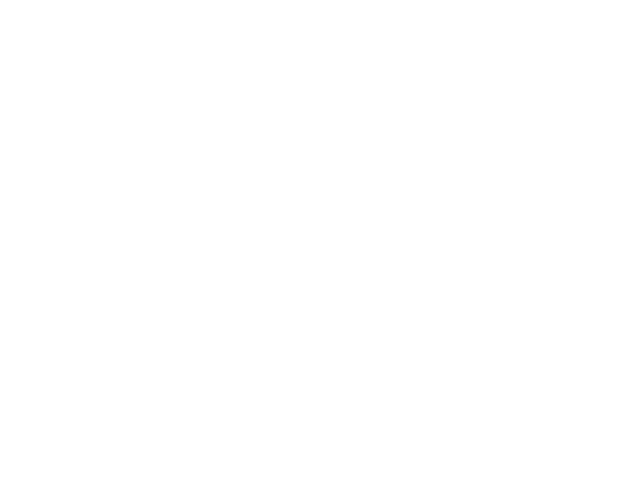

<IPython.core.display.Javascript object>


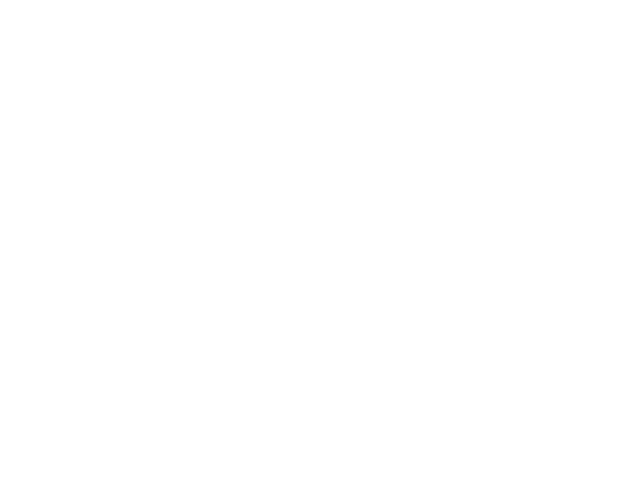

<IPython.core.display.Javascript object>


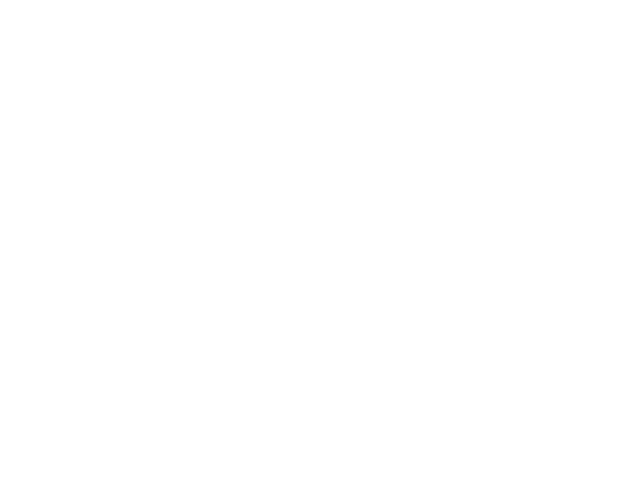

<IPython.core.display.Javascript object>


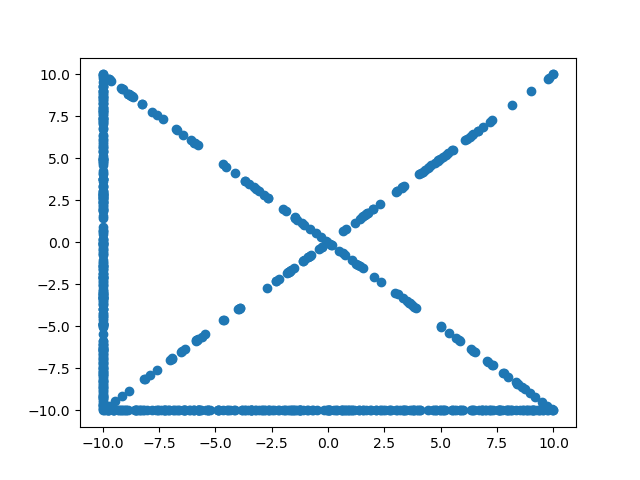

In [30]:
save_datasets_visualization()

In [15]:
%matplotlib notebook

lam = lambda p, vec: calc_det(create_2x2_matrix(p, vec))
pt_classifier = PointClassifier(epsilon, lam)
graham_algorithm_obj = GrahamAlgorithm(pt_classifier)
jarvis_algorithm_obj = JarvisAlgorithm(pt_classifier)

In [26]:
data_name = 'D'

tested_algorithms = {
    'Graham\'s algorithm': graham_algorithm_obj,
    'Jarvis\' algorithm': jarvis_algorithm_obj
}
save_results(tested_algorithms, dataset, data_name)
#save_algorithms_visualisations(tested_algorithms, dataset, data_name)
